# Sample Workflow for d3rlpy Experiments

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import subprocess
import os
import d3rlpy
plt.style.use('matplotlibrc')

from Python.data_sampler import *

## Building an MDPDataset

We first read in a large batch of samples from the file. As `d3rlpy` wants it in the form (observations, actions, rewards, terminal flags), we go ahead and do that. Here's a helper function to get a dataset from a list of chunks of your choosing.

In [57]:
def get_dataset(chunks : list, batch_size=30000, 
                path="collected_data/rl_det_small.txt") -> d3rlpy.dataset.MDPDataset :
    random.seed(0)
    samples = DataSampler(path_to_data=path)
    states = []
    actions = []
    rewards = []
    next_states = []
    for chunk in chunks:
        samples.use_chunk(chunk)
        samples.read_chunk()
        [statesChunk, actionsChunk, rewardsChunk, nextStatesChunk] = samples.get_batch(batch_size)
        states.append(statesChunk)
        actions.append(actionsChunk)
        rewards.append(rewardsChunk)
        next_states.append(nextStatesChunk)
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    terminals = np.zeros(len(states))
    terminals[::100] = 1 #episode length 100, change if necessary
    print(states.shape)
    dataset = d3rlpy.dataset.MDPDataset(states.numpy(), 
                                        actions.numpy(), 
                                        rewards.numpy(), terminals)
    return dataset, states.numpy(), actions.numpy(), rewards.numpy()

We can build the dataset from there, just like this, and split into train and test sets.

In [58]:
dataset, states, actions, rewards = get_dataset([3,5,7,9], path="collected_data/rl_det_small.txt")

[ 0.00000000e+00  7.95731469e+08 -8.17891077e-02 -1.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.09713430e-01 -2.63658359e-01  6.00000000e-01]
Read chunk # 4 out of 10000
[ 0.00000000e+00  7.95731469e+08  1.24610892e-01  2.40000469e-03
 -7.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.20016566e-01  3.79282423e-01 -6.00000000e-01]
Read chunk # 6 out of 10000
[ 0.00000000e+00  7.95731469e+08 -9.01891077e-02  1.08000047e-02
  3.99986580e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.17973088e-02 -2.40776052e-01  6.00000000e-01]
Read chunk # 8 out of 10000
[ 0.00000000e+00  7.95731469e+08  6.91108923e-02 -5.99999531e-03
 -6.00001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.42355434e-01  2.22081792e-01 -6.00000000e-01]
Read chunk # 10 out of 10000
torch.Size([111080, 6])


In [59]:
print("The behavior policy value statistics are:")
dataset.compute_stats()['return']

The behavior policy value statistics are:


{'mean': -4.1227446,
 'std': 2.4676569,
 'min': -12.578855,
 'max': 0.0,
 'histogram': (array([ 26,   9,   7,   7,   8,   7,  10,  13,  27,  54,  56,  73, 109,
          84, 186, 148, 124,  83,  67,  13]),
  array([-12.578855 , -11.949912 , -11.320969 , -10.692026 , -10.063084 ,
          -9.434141 ,  -8.805199 ,  -8.176255 ,  -7.5473127,  -6.9183702,
          -6.2894273,  -5.6604843,  -5.031542 ,  -4.4025993,  -3.7736564,
          -3.1447136,  -2.515771 ,  -1.8868282,  -1.2578855,  -0.6289427,
           0.       ], dtype=float32))}

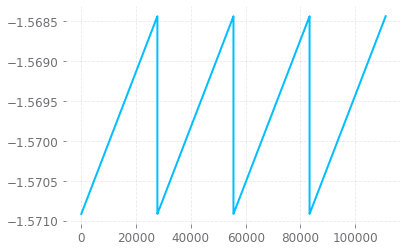

In [100]:
plt.plot(states[:,5])

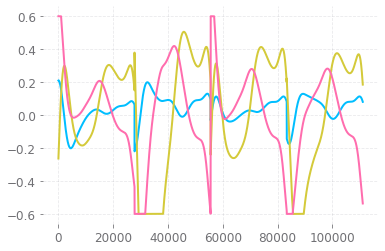

In [40]:
plt.plot(actions)

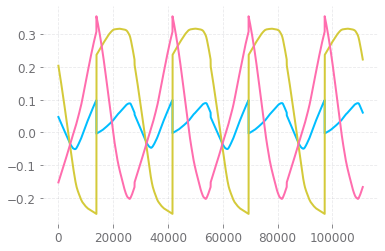

In [46]:
#plt.plot(model.predict(np.array(states)))

In [34]:
from sklearn.model_selection import train_test_split
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

## Setting up an Algorithm

In [83]:
from d3rlpy.algos import CQL
from d3rlpy.models.encoders import VectorEncoderFactory

from d3rlpy.preprocessing import MinMaxActionScaler
action_scaler = MinMaxActionScaler(minimum=-0.6, maximum=0.6)
#cql = CQL(action_scaler=action_scaler)

#actor_encoder = VectorEncoderFactory(hidden_units=[12, 24, 36, 24, 12],
#                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)
#critic_encoder = VectorEncoderFactory(hidden_units=[12, 24, 24, 12],
#                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)

model = CQL(q_func_factory='qr', #qr -> quantile regression q function, but you don't have to use this
            reward_scaler='standard',
            action_scaler=action_scaler,
          actor_learning_rate=1e-5, 
          critic_learning_rate=0.0003, 
            use_gpu=False) #change it to true if you have one
model.build_with_dataset(dataset)

In [84]:
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer

# calculate metrics with test dataset
ave_error_init = average_value_estimation_scorer(model, test_episodes)
print(ave_error_init)

0.0558982342402305


In [8]:
%load_ext tensorboard
%tensorboard --logdir runs

In [85]:
model.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=5, 
        tensorboard_dir='runs',
        scorers={
            'td_error': td_error_scorer,
            'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer
        })

2022-04-11 20:38.20 [debug    ] RoundIterator is selected.
2022-04-11 20:38.20 [info     ] Directory is created at d3rlpy_logs/CQL_20220411203820
2022-04-11 20:38.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-11 20:38.20 [debug    ] Fitting reward scaler...       reward_scaler=standard
2022-04-11 20:38.20 [warning  ] Skip building models since they're already built.
2022-04-11 20:38.20 [info     ] Parameters are saved to d3rlpy_logs/CQL_20220411203820/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [12, 24, 36, 24, 12], 'activation': 'relu', 'use_batch_norm': True, 'dropout_rate': 0.2, 'use_dense': False}}, 'actor_learning_rate': 1e-05, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls

Epoch 1/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:39.01 [info     ] CQL_20220411203820: epoch=1 step=343 epoch=1 metrics={'time_sample_batch': 0.0003712385805980805, 'time_algorithm_update': 0.1121974783805647, 'temp_loss': 2.906333803783005, 'temp': 0.9830607071562342, 'alpha_loss': -16.98576516243181, 'alpha': 1.0175160496297453, 'critic_loss': 32.31512490097357, 'actor_loss': 0.043033430532011974, 'time_step': 0.11265468110843581, 'td_error': 0.5833314859319215, 'init_value': 0.2512402832508087, 'ave_value': 0.25088928373278324} step=343
2022-04-11 20:39.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411203820/model_343.pt


Epoch 2/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:39.41 [info     ] CQL_20220411203820: epoch=2 step=686 epoch=2 metrics={'time_sample_batch': 0.00036962525837622997, 'time_algorithm_update': 0.11178588728167921, 'temp_loss': 2.9525378994621967, 'temp': 0.9498408706125643, 'alpha_loss': -17.852475547234448, 'alpha': 1.0538248261626886, 'critic_loss': 28.698780715986867, 'actor_loss': 0.022248131166003188, 'time_step': 0.11224036383559335, 'td_error': 0.5859051389133153, 'init_value': 0.24752359092235565, 'ave_value': 0.24675161608876975} step=686
2022-04-11 20:39.41 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411203820/model_686.pt


Epoch 3/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:40.22 [info     ] CQL_20220411203820: epoch=3 step=1029 epoch=3 metrics={'time_sample_batch': 0.00036996585634637504, 'time_algorithm_update': 0.11270226125466928, 'temp_loss': 2.9545705200284287, 'temp': 0.9176540696238638, 'alpha_loss': -18.572775676716173, 'alpha': 1.0920375331845298, 'critic_loss': 29.00543953030867, 'actor_loss': 0.038751925645890285, 'time_step': 0.11315861596310452, 'td_error': 0.620375980590574, 'init_value': 0.10807143151760101, 'ave_value': 0.10673181302764483} step=1029
2022-04-11 20:40.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411203820/model_1029.pt


Epoch 4/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:41.02 [info     ] CQL_20220411203820: epoch=4 step=1372 epoch=4 metrics={'time_sample_batch': 0.0003685422958507482, 'time_algorithm_update': 0.1113182810235649, 'temp_loss': 2.9380900790322975, 'temp': 0.8866981219272224, 'alpha_loss': -19.242598486363715, 'alpha': 1.1320549329585305, 'critic_loss': 30.44792308195687, 'actor_loss': 0.08062201617801502, 'time_step': 0.11177324067051835, 'td_error': 0.6800266180167694, 'init_value': -0.0789547935128212, 'ave_value': -0.08039216859688099} step=1372
2022-04-11 20:41.02 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411203820/model_1372.pt


Epoch 5/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-11 20:41.42 [info     ] CQL_20220411203820: epoch=5 step=1715 epoch=5 metrics={'time_sample_batch': 0.00036880295756259394, 'time_algorithm_update': 0.11047571393560737, 'temp_loss': 2.9130296102418147, 'temp': 0.8569826063192273, 'alpha_loss': -19.94834636877299, 'alpha': 1.1738424964965954, 'critic_loss': 32.46413976040943, 'actor_loss': 0.199312857314184, 'time_step': 0.11093110245796403, 'td_error': 0.7290366590368804, 'init_value': -0.34277060627937317, 'ave_value': -0.3436818885281881} step=1715
2022-04-11 20:41.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220411203820/model_1715.pt


[(1,
  {'time_sample_batch': 0.0003712385805980805,
   'time_algorithm_update': 0.1121974783805647,
   'temp_loss': 2.906333803783005,
   'temp': 0.9830607071562342,
   'alpha_loss': -16.98576516243181,
   'alpha': 1.0175160496297453,
   'critic_loss': 32.31512490097357,
   'actor_loss': 0.043033430532011974,
   'time_step': 0.11265468110843581,
   'td_error': 0.5833314859319215,
   'init_value': 0.2512402832508087,
   'ave_value': 0.25088928373278324}),
 (2,
  {'time_sample_batch': 0.00036962525837622997,
   'time_algorithm_update': 0.11178588728167921,
   'temp_loss': 2.9525378994621967,
   'temp': 0.9498408706125643,
   'alpha_loss': -17.852475547234448,
   'alpha': 1.0538248261626886,
   'critic_loss': 28.698780715986867,
   'actor_loss': 0.022248131166003188,
   'time_step': 0.11224036383559335,
   'td_error': 0.5859051389133153,
   'init_value': 0.24752359092235565,
   'ave_value': 0.24675161608876975}),
 (3,
  {'time_sample_batch': 0.00036996585634637504,
   'time_algorithm_upda

## Off-Policy Evaluation

We do get some metrics on a test set of initial state value and average value. However, these estimates (using the critic's Q-function) of model performance are biased. They're useful for validation during training, but not much else. Instead, we fit a Q-function to the data (or a separate dataset, as I've done here) separately and evaluate the model's performance on it.

Feel free to change the chunks and number of steps.

In [86]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope = get_dataset([2,4,6,8], path="collected_data/rl_det_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes,
        eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08  7.01089229e-03 -4.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.21623335e-01 -2.86362315e-02 -8.00043364e-02]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01 -1.37999953e-02
  7.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.76352555e-01 -3.26280816e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-11 20:41.43 [debug    ] RoundIterator is selected.
2022-04-11 20:41.43 [info     ] Directory is created at d3rlpy_logs/FQE_2022041120414

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.46 [info     ] FQE_20220411204143: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00013390597558510332, 'time_algorithm_update': 0.0023726292786131146, 'loss': 0.00040634638490485574, 'time_step': 0.0025694411001878884, 'init_value': -0.01200774870812893, 'ave_value': -0.01214047999538049, 'soft_opc': nan} step=878


2022-04-11 20:41.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.48 [info     ] FQE_20220411204143: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.0001311375502844878, 'time_algorithm_update': 0.002201966381290236, 'loss': 0.00015653447553890817, 'time_step': 0.0023923914090375966, 'init_value': -0.18698522448539734, 'ave_value': -0.18708628190151239, 'soft_opc': nan} step=1756


2022-04-11 20:41.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.51 [info     ] FQE_20220411204143: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00012940616433875708, 'time_algorithm_update': 0.00238649557283093, 'loss': 0.0006476881085213407, 'time_step': 0.0025771332221585144, 'init_value': -0.34971967339515686, 'ave_value': -0.34979035689837584, 'soft_opc': nan} step=2634


2022-04-11 20:41.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.54 [info     ] FQE_20220411204143: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00012428966904555475, 'time_algorithm_update': 0.0021790890595907502, 'loss': 0.0014080711788963542, 'time_step': 0.0023558536260166038, 'init_value': -0.44196727871894836, 'ave_value': -0.4420031776202299, 'soft_opc': nan} step=3512


2022-04-11 20:41.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.57 [info     ] FQE_20220411204143: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.0001301692124108247, 'time_algorithm_update': 0.002459561634715434, 'loss': 0.002319906632947261, 'time_step': 0.0026482479447384358, 'init_value': -0.5267728567123413, 'ave_value': -0.5268005141328198, 'soft_opc': nan} step=4390


2022-04-11 20:41.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:41.59 [info     ] FQE_20220411204143: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.00012963372102359433, 'time_algorithm_update': 0.002393775214366869, 'loss': 0.003163371314328178, 'time_step': 0.0025805291934002505, 'init_value': -0.5963505506515503, 'ave_value': -0.5963794378103183, 'soft_opc': nan} step=5268


2022-04-11 20:41.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.02 [info     ] FQE_20220411204143: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.0001274643291916554, 'time_algorithm_update': 0.002233491943202964, 'loss': 0.00345480580247118, 'time_step': 0.0024188249149192168, 'init_value': -0.5923312306404114, 'ave_value': -0.5923364250406264, 'soft_opc': nan} step=6146


2022-04-11 20:42.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.05 [info     ] FQE_20220411204143: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.00013093932071416416, 'time_algorithm_update': 0.0024372173604769697, 'loss': 0.003421626170221256, 'time_step': 0.002628661505453679, 'init_value': -0.6151825785636902, 'ave_value': -0.615195662942805, 'soft_opc': nan} step=7024


2022-04-11 20:42.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.08 [info     ] FQE_20220411204143: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.00013087252006443867, 'time_algorithm_update': 0.002447470445567763, 'loss': 0.004119189605700537, 'time_step': 0.0026374672431337533, 'init_value': -0.6864761114120483, 'ave_value': -0.6864563968943292, 'soft_opc': nan} step=7902


2022-04-11 20:42.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.11 [info     ] FQE_20220411204143: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.0001308879982637653, 'time_algorithm_update': 0.0024794940253325096, 'loss': 0.004989227952181841, 'time_step': 0.0026697699735810927, 'init_value': -0.7273063659667969, 'ave_value': -0.7273207277379488, 'soft_opc': nan} step=8780


2022-04-11 20:42.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.13 [info     ] FQE_20220411204143: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.00012841067172943322, 'time_algorithm_update': 0.002420402333513751, 'loss': 0.005516199878152945, 'time_step': 0.002608247661373338, 'init_value': -0.7780561447143555, 'ave_value': -0.7780606159023677, 'soft_opc': nan} step=9658


2022-04-11 20:42.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.16 [info     ] FQE_20220411204143: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00012913434543479276, 'time_algorithm_update': 0.0024281300281880926, 'loss': 0.006379649547916456, 'time_step': 0.0026174501297414167, 'init_value': -0.7929844856262207, 'ave_value': -0.7930121093862875, 'soft_opc': nan} step=10536


2022-04-11 20:42.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.19 [info     ] FQE_20220411204143: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00012944825417903125, 'time_algorithm_update': 0.0023920381259266497, 'loss': 0.005983506354252711, 'time_step': 0.002582679033822514, 'init_value': -0.7703137397766113, 'ave_value': -0.7703164160243517, 'soft_opc': nan} step=11414


2022-04-11 20:42.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.22 [info     ] FQE_20220411204143: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00012870014121157706, 'time_algorithm_update': 0.002432157075486585, 'loss': 0.005884410997967399, 'time_step': 0.0026210350979433516, 'init_value': -0.7653180360794067, 'ave_value': -0.76533197613629, 'soft_opc': nan} step=12292


2022-04-11 20:42.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.25 [info     ] FQE_20220411204143: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.0001287161625056169, 'time_algorithm_update': 0.0024155356617886277, 'loss': 0.00560213429763479, 'time_step': 0.002604074521596991, 'init_value': -0.7502255439758301, 'ave_value': -0.7502158145900869, 'soft_opc': nan} step=13170


2022-04-11 20:42.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.27 [info     ] FQE_20220411204143: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.0001287012274010035, 'time_algorithm_update': 0.002400904961761961, 'loss': 0.005736323902634822, 'time_step': 0.0025882435822541187, 'init_value': -0.7908921837806702, 'ave_value': -0.7908659912961362, 'soft_opc': nan} step=14048


2022-04-11 20:42.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.30 [info     ] FQE_20220411204143: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.00013028597777416603, 'time_algorithm_update': 0.002403886551737514, 'loss': 0.006364336764234059, 'time_step': 0.0025945421231906344, 'init_value': -0.7889370322227478, 'ave_value': -0.7889060147480239, 'soft_opc': nan} step=14926


2022-04-11 20:42.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.33 [info     ] FQE_20220411204143: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.0001302175478403009, 'time_algorithm_update': 0.0024386383677940976, 'loss': 0.006879242236974901, 'time_step': 0.0026281751641379944, 'init_value': -0.8079676032066345, 'ave_value': -0.8079022830523037, 'soft_opc': nan} step=15804


2022-04-11 20:42.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.36 [info     ] FQE_20220411204143: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00013082282689817946, 'time_algorithm_update': 0.002443148497839995, 'loss': 0.0069300417534591185, 'time_step': 0.002635552834269669, 'init_value': -0.8338174819946289, 'ave_value': -0.8336825076558643, 'soft_opc': nan} step=16682


2022-04-11 20:42.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.39 [info     ] FQE_20220411204143: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012697527240240492, 'time_algorithm_update': 0.002246931636523549, 'loss': 0.007182088389054177, 'time_step': 0.0024337328647969793, 'init_value': -0.8736714720726013, 'ave_value': -0.8735269287193351, 'soft_opc': nan} step=17560


2022-04-11 20:42.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.41 [info     ] FQE_20220411204143: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00012893231420147664, 'time_algorithm_update': 0.002400401241415454, 'loss': 0.007025318307115021, 'time_step': 0.0025905243085022666, 'init_value': -0.8427948951721191, 'ave_value': -0.8426670844493237, 'soft_opc': nan} step=18438


2022-04-11 20:42.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.44 [info     ] FQE_20220411204143: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.00013763432079132705, 'time_algorithm_update': 0.002488909658375525, 'loss': 0.007223890597647565, 'time_step': 0.002686273807273639, 'init_value': -0.8387035131454468, 'ave_value': -0.8385855295862544, 'soft_opc': nan} step=19316


2022-04-11 20:42.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.47 [info     ] FQE_20220411204143: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00012922938700960545, 'time_algorithm_update': 0.002426838820507423, 'loss': 0.007070777845991723, 'time_step': 0.002615940326438678, 'init_value': -0.8237708210945129, 'ave_value': -0.8236628802956493, 'soft_opc': nan} step=20194


2022-04-11 20:42.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.50 [info     ] FQE_20220411204143: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00012720228599252895, 'time_algorithm_update': 0.002383458858741986, 'loss': 0.007301265632588664, 'time_step': 0.0025710475743495795, 'init_value': -0.8516121506690979, 'ave_value': -0.8515067224691121, 'soft_opc': nan} step=21072


2022-04-11 20:42.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.53 [info     ] FQE_20220411204143: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00012754742268277736, 'time_algorithm_update': 0.0023935710107547002, 'loss': 0.006957638943434286, 'time_step': 0.0025815325608829157, 'init_value': -0.835426926612854, 'ave_value': -0.8353090143891658, 'soft_opc': nan} step=21950


2022-04-11 20:42.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.56 [info     ] FQE_20220411204143: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.00013036771352850494, 'time_algorithm_update': 0.002435799340180764, 'loss': 0.00672367208082437, 'time_step': 0.0026280464506909626, 'init_value': -0.8160561919212341, 'ave_value': -0.8159522286639426, 'soft_opc': nan} step=22828


2022-04-11 20:42.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:42.58 [info     ] FQE_20220411204143: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.00012939367316035312, 'time_algorithm_update': 0.0024253284741099714, 'loss': 0.00639230245818999, 'time_step': 0.0026162756874240885, 'init_value': -0.8290807604789734, 'ave_value': -0.8289882333570132, 'soft_opc': nan} step=23706


2022-04-11 20:42.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.01 [info     ] FQE_20220411204143: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00012656414970450087, 'time_algorithm_update': 0.0024053015850127963, 'loss': 0.006932332084167097, 'time_step': 0.0025911925865468783, 'init_value': -0.8487645387649536, 'ave_value': -0.8486734230152133, 'soft_opc': nan} step=24584


2022-04-11 20:43.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.04 [info     ] FQE_20220411204143: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012786866320564427, 'time_algorithm_update': 0.0023851489694895127, 'loss': 0.007045077208637014, 'time_step': 0.0025742279369901687, 'init_value': -0.829268753528595, 'ave_value': -0.8291410300704336, 'soft_opc': nan} step=25462


2022-04-11 20:43.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.07 [info     ] FQE_20220411204143: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.00012950717995541513, 'time_algorithm_update': 0.0024187135805030075, 'loss': 0.006956927151014996, 'time_step': 0.0026081382277886255, 'init_value': -0.8485906720161438, 'ave_value': -0.848470157026602, 'soft_opc': nan} step=26340


2022-04-11 20:43.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.09 [info     ] FQE_20220411204143: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00012854508767095406, 'time_algorithm_update': 0.002293134876155636, 'loss': 0.006961467199115446, 'time_step': 0.002481711752593925, 'init_value': -0.8281146287918091, 'ave_value': -0.8280121283173296, 'soft_opc': nan} step=27218


2022-04-11 20:43.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.12 [info     ] FQE_20220411204143: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00013171485996463575, 'time_algorithm_update': 0.0024283782224720322, 'loss': 0.006799057003537948, 'time_step': 0.0026206766554326293, 'init_value': -0.8222630023956299, 'ave_value': -0.8221594725726669, 'soft_opc': nan} step=28096


2022-04-11 20:43.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.15 [info     ] FQE_20220411204143: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.00012944146549511608, 'time_algorithm_update': 0.0024180499187634583, 'loss': 0.006793963002057792, 'time_step': 0.002609018312771391, 'init_value': -0.8180257081985474, 'ave_value': -0.8179173629536719, 'soft_opc': nan} step=28974


2022-04-11 20:43.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.18 [info     ] FQE_20220411204143: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.00013039676909566198, 'time_algorithm_update': 0.0024449238744574963, 'loss': 0.006472035411425199, 'time_step': 0.0026360910411304655, 'init_value': -0.8244957327842712, 'ave_value': -0.8243959553972742, 'soft_opc': nan} step=29852


2022-04-11 20:43.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.21 [info     ] FQE_20220411204143: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.0001277111657388118, 'time_algorithm_update': 0.0024217125495093832, 'loss': 0.006441344826040752, 'time_step': 0.0026110587196089413, 'init_value': -0.7990365624427795, 'ave_value': -0.7989493437628062, 'soft_opc': nan} step=30730


2022-04-11 20:43.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.24 [info     ] FQE_20220411204143: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.0001294067074334703, 'time_algorithm_update': 0.002437760998284898, 'loss': 0.006245587157435391, 'time_step': 0.0026276103456362504, 'init_value': -0.7864933013916016, 'ave_value': -0.7864127634751676, 'soft_opc': nan} step=31608


2022-04-11 20:43.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.26 [info     ] FQE_20220411204143: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00012737526165868806, 'time_algorithm_update': 0.0023840532759056006, 'loss': 0.00608571211134413, 'time_step': 0.0025710163464035696, 'init_value': -0.8009018898010254, 'ave_value': -0.8008074992084361, 'soft_opc': nan} step=32486


2022-04-11 20:43.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.29 [info     ] FQE_20220411204143: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.000129375751034817, 'time_algorithm_update': 0.0023976423202723197, 'loss': 0.006098112753370298, 'time_step': 0.002588363063091026, 'init_value': -0.7564612627029419, 'ave_value': -0.7563600643349497, 'soft_opc': nan} step=33364


2022-04-11 20:43.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.32 [info     ] FQE_20220411204143: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00012858609132180182, 'time_algorithm_update': 0.0023980550722543636, 'loss': 0.005445306874351731, 'time_step': 0.0025889248945718474, 'init_value': -0.7179614305496216, 'ave_value': -0.71785247934174, 'soft_opc': nan} step=34242


2022-04-11 20:43.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.35 [info     ] FQE_20220411204143: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00012638601463856622, 'time_algorithm_update': 0.002227129860185002, 'loss': 0.00537163212360365, 'time_step': 0.0024115308813733773, 'init_value': -0.7450554966926575, 'ave_value': -0.744968068782211, 'soft_opc': nan} step=35120


2022-04-11 20:43.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.37 [info     ] FQE_20220411204143: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.0001304893667442652, 'time_algorithm_update': 0.002289074428532281, 'loss': 0.00542862397647475, 'time_step': 0.0024802272031953505, 'init_value': -0.7431577444076538, 'ave_value': -0.7430566472787327, 'soft_opc': nan} step=35998


2022-04-11 20:43.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.40 [info     ] FQE_20220411204143: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.000130502672564739, 'time_algorithm_update': 0.0024421804315136885, 'loss': 0.005502084823029775, 'time_step': 0.0026333315768926184, 'init_value': -0.7368717193603516, 'ave_value': -0.7367670793121219, 'soft_opc': nan} step=36876


2022-04-11 20:43.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.43 [info     ] FQE_20220411204143: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00012975510269199798, 'time_algorithm_update': 0.0024467980943128024, 'loss': 0.005824008255540642, 'time_step': 0.0026376141502536784, 'init_value': -0.7754924893379211, 'ave_value': -0.7753808917426683, 'soft_opc': nan} step=37754


2022-04-11 20:43.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.46 [info     ] FQE_20220411204143: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.00012835799154225133, 'time_algorithm_update': 0.002420049321950161, 'loss': 0.006054422521938229, 'time_step': 0.0026084570243852826, 'init_value': -0.7887305021286011, 'ave_value': -0.7886188403578531, 'soft_opc': nan} step=38632


2022-04-11 20:43.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.49 [info     ] FQE_20220411204143: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.0001267379400127298, 'time_algorithm_update': 0.002369880133174818, 'loss': 0.005870532910705217, 'time_step': 0.0025556011460636636, 'init_value': -0.7686200737953186, 'ave_value': -0.7684973528912498, 'soft_opc': nan} step=39510


2022-04-11 20:43.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.51 [info     ] FQE_20220411204143: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00012896191286334687, 'time_algorithm_update': 0.0024082337533694463, 'loss': 0.006069147616262791, 'time_step': 0.0025969249512448668, 'init_value': -0.7787361741065979, 'ave_value': -0.7786064036742292, 'soft_opc': nan} step=40388


2022-04-11 20:43.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.54 [info     ] FQE_20220411204143: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.00012846280882190193, 'time_algorithm_update': 0.0023980833131794508, 'loss': 0.006209886305702136, 'time_step': 0.002586975999193474, 'init_value': -0.8052405118942261, 'ave_value': -0.8050659670477496, 'soft_opc': nan} step=41266


2022-04-11 20:43.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:43.57 [info     ] FQE_20220411204143: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00012806770741803771, 'time_algorithm_update': 0.002397700974501347, 'loss': 0.006523059192040083, 'time_step': 0.00258648721395158, 'init_value': -0.8026303648948669, 'ave_value': -0.8024660324296555, 'soft_opc': nan} step=42144


2022-04-11 20:43.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.00 [info     ] FQE_20220411204143: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00012830639754449587, 'time_algorithm_update': 0.0023926086469228825, 'loss': 0.006499066591368888, 'time_step': 0.002582150602666555, 'init_value': -0.780935525894165, 'ave_value': -0.7807544622996009, 'soft_opc': nan} step=43022


2022-04-11 20:44.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.03 [info     ] FQE_20220411204143: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00013055236573099817, 'time_algorithm_update': 0.0024508294863690005, 'loss': 0.006214626529749321, 'time_step': 0.0026436824190317907, 'init_value': -0.7760704755783081, 'ave_value': -0.7759105742217979, 'soft_opc': nan} step=43900


2022-04-11 20:44.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204143/model_43900.pt


[(1,
  {'time_sample_batch': 0.00013390597558510332,
   'time_algorithm_update': 0.0023726292786131146,
   'loss': 0.00040634638490485574,
   'time_step': 0.0025694411001878884,
   'init_value': -0.01200774870812893,
   'ave_value': -0.01214047999538049,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.0001311375502844878,
   'time_algorithm_update': 0.002201966381290236,
   'loss': 0.00015653447553890817,
   'time_step': 0.0023923914090375966,
   'init_value': -0.18698522448539734,
   'ave_value': -0.18708628190151239,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00012940616433875708,
   'time_algorithm_update': 0.00238649557283093,
   'loss': 0.0006476881085213407,
   'time_step': 0.0025771332221585144,
   'init_value': -0.34971967339515686,
   'ave_value': -0.34979035689837584,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00012428966904555475,
   'time_algorithm_update': 0.0021790890595907502,
   'loss': 0.0014080711788963542,
   'time_step': 0.002355853626016603

In [87]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope = get_dataset([2,4,6,8], path="collected_data/rl_stoch_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08  1.39310892e-01  1.82000047e-02
 -1.00013420e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -7.50230117e-02  3.69851546e-01 -6.00000000e-01]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.15389108e-01  1.64000047e-02
 -8.80001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.08831172e-01 -2.48178665e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.28589108e-01  1.20000047e-02
  1.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  7.75212759e-03 -3.52719043e-01  6.00000000e-01]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01  7.00000469e-03
 -8.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.65974295e-01 -2.19295880e-01  6.00000000e-01]
Read chunk # 9 out of 10000
torch.Size([111080, 6])
2022-04-11 20:44.03 [debug    ] RoundIterator is selected.
2022-04-11 20:44.03 [info     ] Directory is created at d3rlpy_logs/FQE_2022041120440

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.06 [info     ] FQE_20220411204403: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00013408628302989081, 'time_algorithm_update': 0.0023135261818053783, 'loss': 0.00027120412625564004, 'time_step': 0.002509258874184993, 'init_value': -0.14793483912944794, 'ave_value': -0.14778517369033606, 'soft_opc': nan} step=878


2022-04-11 20:44.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.09 [info     ] FQE_20220411204403: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00013296696482595387, 'time_algorithm_update': 0.002306159102020611, 'loss': 0.0006913076719056149, 'time_step': 0.002500932960684044, 'init_value': -0.2677631378173828, 'ave_value': -0.26754019071464064, 'soft_opc': nan} step=1756


2022-04-11 20:44.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.11 [info     ] FQE_20220411204403: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00012608676945158453, 'time_algorithm_update': 0.0022115120855170666, 'loss': 0.001205801250931153, 'time_step': 0.0023915887150514643, 'init_value': -0.36915361881256104, 'ave_value': -0.36889894135084067, 'soft_opc': nan} step=2634


2022-04-11 20:44.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.14 [info     ] FQE_20220411204403: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00012843918420187705, 'time_algorithm_update': 0.0022516524873181735, 'loss': 0.0018025190169829663, 'time_step': 0.0024366672055324825, 'init_value': -0.41623663902282715, 'ave_value': -0.4159534695429712, 'soft_opc': nan} step=3512


2022-04-11 20:44.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.17 [info     ] FQE_20220411204403: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.0001273228530188628, 'time_algorithm_update': 0.002220409877751031, 'loss': 0.0020712417367151855, 'time_step': 0.0024032456999759197, 'init_value': -0.4310553967952728, 'ave_value': -0.4307664307640499, 'soft_opc': nan} step=4390


2022-04-11 20:44.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.19 [info     ] FQE_20220411204403: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.0001273975285419299, 'time_algorithm_update': 0.0022064363223273553, 'loss': 0.002540533532730503, 'time_step': 0.002389106500664713, 'init_value': -0.4986552894115448, 'ave_value': -0.49833026983688594, 'soft_opc': nan} step=5268


2022-04-11 20:44.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.22 [info     ] FQE_20220411204403: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.00012668145816255538, 'time_algorithm_update': 0.002200680876104055, 'loss': 0.0030235561785006615, 'time_step': 0.002384079615999191, 'init_value': -0.5438007116317749, 'ave_value': -0.5434816426475578, 'soft_opc': nan} step=6146


2022-04-11 20:44.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.25 [info     ] FQE_20220411204403: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.0001253112302011129, 'time_algorithm_update': 0.0022012448799637293, 'loss': 0.0033286342717865885, 'time_step': 0.0023820568597398206, 'init_value': -0.5580506920814514, 'ave_value': -0.5577168073526256, 'soft_opc': nan} step=7024


2022-04-11 20:44.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.27 [info     ] FQE_20220411204403: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.0001270912231236764, 'time_algorithm_update': 0.0022392186054064635, 'loss': 0.003378420154984265, 'time_step': 0.002426321251245729, 'init_value': -0.5983646512031555, 'ave_value': -0.5980190249033293, 'soft_opc': nan} step=7902


2022-04-11 20:44.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.30 [info     ] FQE_20220411204403: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.00012427201846737526, 'time_algorithm_update': 0.002211547658220782, 'loss': 0.003988003705958808, 'time_step': 0.0023928989310470963, 'init_value': -0.6144134998321533, 'ave_value': -0.6140652529001992, 'soft_opc': nan} step=8780


2022-04-11 20:44.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.32 [info     ] FQE_20220411204403: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.0001249821148049044, 'time_algorithm_update': 0.0022173680042623114, 'loss': 0.004528152022557108, 'time_step': 0.002400917724487722, 'init_value': -0.6761484146118164, 'ave_value': -0.6757682951166128, 'soft_opc': nan} step=9658


2022-04-11 20:44.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.35 [info     ] FQE_20220411204403: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00012325751754308889, 'time_algorithm_update': 0.0021552328096706938, 'loss': 0.004935397817027151, 'time_step': 0.0023350096509233966, 'init_value': -0.6666867136955261, 'ave_value': -0.6662796237526011, 'soft_opc': nan} step=10536


2022-04-11 20:44.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.38 [info     ] FQE_20220411204403: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00012635532978726955, 'time_algorithm_update': 0.0022128432106591576, 'loss': 0.005083986961397589, 'time_step': 0.0023973683289895027, 'init_value': -0.6745490431785583, 'ave_value': -0.6741134700848258, 'soft_opc': nan} step=11414


2022-04-11 20:44.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.40 [info     ] FQE_20220411204403: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00012539323750280845, 'time_algorithm_update': 0.0022013233571497887, 'loss': 0.004902776370353275, 'time_step': 0.0023840054835708377, 'init_value': -0.6708903908729553, 'ave_value': -0.6704595345964455, 'soft_opc': nan} step=12292


2022-04-11 20:44.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.43 [info     ] FQE_20220411204403: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.00012560884610395497, 'time_algorithm_update': 0.002189413833183688, 'loss': 0.004889680554605214, 'time_step': 0.0023734376750937356, 'init_value': -0.6995647549629211, 'ave_value': -0.6991270856834189, 'soft_opc': nan} step=13170


2022-04-11 20:44.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.45 [info     ] FQE_20220411204403: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.0001284098570873634, 'time_algorithm_update': 0.0022197081993815568, 'loss': 0.005300152563750359, 'time_step': 0.0024060097805188294, 'init_value': -0.6975634098052979, 'ave_value': -0.697102720301863, 'soft_opc': nan} step=14048


2022-04-11 20:44.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.48 [info     ] FQE_20220411204403: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.0001319706575745602, 'time_algorithm_update': 0.00233378144222946, 'loss': 0.0055057591485242, 'time_step': 0.002527207068267336, 'init_value': -0.7125281095504761, 'ave_value': -0.7120647023916622, 'soft_opc': nan} step=14926


2022-04-11 20:44.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.51 [info     ] FQE_20220411204403: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00013329173546445668, 'time_algorithm_update': 0.002341992491198564, 'loss': 0.005507610597730464, 'time_step': 0.002537085961100724, 'init_value': -0.7214574217796326, 'ave_value': -0.7210138147954098, 'soft_opc': nan} step=15804


2022-04-11 20:44.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.54 [info     ] FQE_20220411204403: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00012827788507205207, 'time_algorithm_update': 0.0022350530689561015, 'loss': 0.005746069137464406, 'time_step': 0.0024253675769293228, 'init_value': -0.759974479675293, 'ave_value': -0.7595141987864422, 'soft_opc': nan} step=16682


2022-04-11 20:44.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.56 [info     ] FQE_20220411204403: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012868574920167684, 'time_algorithm_update': 0.002247848651946813, 'loss': 0.005991865344304624, 'time_step': 0.0024362807936440297, 'init_value': -0.7680994272232056, 'ave_value': -0.767638745992119, 'soft_opc': nan} step=17560


2022-04-11 20:44.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:44.59 [info     ] FQE_20220411204403: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00012935945819342055, 'time_algorithm_update': 0.0022276145722165464, 'loss': 0.005982003253111729, 'time_step': 0.002420210621079986, 'init_value': -0.7345473170280457, 'ave_value': -0.7340441333263222, 'soft_opc': nan} step=18438


2022-04-11 20:44.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.02 [info     ] FQE_20220411204403: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.0001274398899295607, 'time_algorithm_update': 0.0022578318189651384, 'loss': 0.00578042924083534, 'time_step': 0.0024458455061858227, 'init_value': -0.7405226230621338, 'ave_value': -0.7400344934965998, 'soft_opc': nan} step=19316


2022-04-11 20:45.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.04 [info     ] FQE_20220411204403: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00012529059260201074, 'time_algorithm_update': 0.002169293260248484, 'loss': 0.005876115805833235, 'time_step': 0.002354983588286033, 'init_value': -0.7500829100608826, 'ave_value': -0.7496116140436078, 'soft_opc': nan} step=20194


2022-04-11 20:45.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.07 [info     ] FQE_20220411204403: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.0001246961754383965, 'time_algorithm_update': 0.0021697318092294055, 'loss': 0.005848645044840347, 'time_step': 0.0023515455272040226, 'init_value': -0.7283217906951904, 'ave_value': -0.7278212948357243, 'soft_opc': nan} step=21072


2022-04-11 20:45.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.09 [info     ] FQE_20220411204403: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.000127160739246968, 'time_algorithm_update': 0.002206298104722842, 'loss': 0.005622167264167716, 'time_step': 0.0023920921638506147, 'init_value': -0.7341170310974121, 'ave_value': -0.7336473568032691, 'soft_opc': nan} step=21950


2022-04-11 20:45.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.12 [info     ] FQE_20220411204403: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.00012992373360045135, 'time_algorithm_update': 0.0022394382872179593, 'loss': 0.005472915758963524, 'time_step': 0.0024294473044149966, 'init_value': -0.735887348651886, 'ave_value': -0.7353847637383106, 'soft_opc': nan} step=22828


2022-04-11 20:45.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.15 [info     ] FQE_20220411204403: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.00012752977210459785, 'time_algorithm_update': 0.0022555331705914543, 'loss': 0.005490216119561661, 'time_step': 0.002444123352850217, 'init_value': -0.685608983039856, 'ave_value': -0.6851266069910517, 'soft_opc': nan} step=23706


2022-04-11 20:45.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.17 [info     ] FQE_20220411204403: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00012880550158594084, 'time_algorithm_update': 0.0023580895469509115, 'loss': 0.005069159921995772, 'time_step': 0.0025472315134383006, 'init_value': -0.6947418451309204, 'ave_value': -0.6942756866401167, 'soft_opc': nan} step=24584


2022-04-11 20:45.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.20 [info     ] FQE_20220411204403: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012732448230300242, 'time_algorithm_update': 0.0021892481892961577, 'loss': 0.005087327960666373, 'time_step': 0.002375738224298916, 'init_value': -0.6837432980537415, 'ave_value': -0.6832727374587526, 'soft_opc': nan} step=25462


2022-04-11 20:45.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.23 [info     ] FQE_20220411204403: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.0001287020420430733, 'time_algorithm_update': 0.0022189294015628057, 'loss': 0.005122677678470499, 'time_step': 0.002408004838947826, 'init_value': -0.7037049531936646, 'ave_value': -0.7032355677499964, 'soft_opc': nan} step=26340


2022-04-11 20:45.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.25 [info     ] FQE_20220411204403: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00012843456789681472, 'time_algorithm_update': 0.0022628369798421318, 'loss': 0.005339351520738993, 'time_step': 0.002452613552501913, 'init_value': -0.7058908939361572, 'ave_value': -0.7054260660622838, 'soft_opc': nan} step=27218


2022-04-11 20:45.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.28 [info     ] FQE_20220411204403: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00012591460842749524, 'time_algorithm_update': 0.002191966106788444, 'loss': 0.005071525291168551, 'time_step': 0.0023773805427116795, 'init_value': -0.6713757514953613, 'ave_value': -0.6709164102780417, 'soft_opc': nan} step=28096


2022-04-11 20:45.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.30 [info     ] FQE_20220411204403: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.00012693698422512324, 'time_algorithm_update': 0.0022174882997412887, 'loss': 0.004978876541306005, 'time_step': 0.0024042314168804054, 'init_value': -0.6622893214225769, 'ave_value': -0.661861112784145, 'soft_opc': nan} step=28974


2022-04-11 20:45.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.33 [info     ] FQE_20220411204403: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.00012993622477885532, 'time_algorithm_update': 0.002261945218323032, 'loss': 0.004667162814902438, 'time_step': 0.0024526857840987707, 'init_value': -0.6627212166786194, 'ave_value': -0.6623135731478027, 'soft_opc': nan} step=29852


2022-04-11 20:45.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.36 [info     ] FQE_20220411204403: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.00013253221750802495, 'time_algorithm_update': 0.0022685345864784743, 'loss': 0.0046596156214128645, 'time_step': 0.0024632446315131047, 'init_value': -0.655255913734436, 'ave_value': -0.6548438756981692, 'soft_opc': nan} step=30730


2022-04-11 20:45.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.38 [info     ] FQE_20220411204403: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.00012769107123442283, 'time_algorithm_update': 0.002259854032129796, 'loss': 0.004516716642867989, 'time_step': 0.0024476800801270645, 'init_value': -0.674893319606781, 'ave_value': -0.6745095670617415, 'soft_opc': nan} step=31608


2022-04-11 20:45.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.41 [info     ] FQE_20220411204403: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.0001286914516961656, 'time_algorithm_update': 0.0021986640938865295, 'loss': 0.004935728938582215, 'time_step': 0.002387359636519656, 'init_value': -0.7027469277381897, 'ave_value': -0.7023155016665734, 'soft_opc': nan} step=32486


2022-04-11 20:45.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.44 [info     ] FQE_20220411204403: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.0001277288163169913, 'time_algorithm_update': 0.0021493334433483917, 'loss': 0.0048479623159999805, 'time_step': 0.002335756949248781, 'init_value': -0.6699589490890503, 'ave_value': -0.6695626315112325, 'soft_opc': nan} step=33364


2022-04-11 20:45.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.46 [info     ] FQE_20220411204403: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00012870502906399598, 'time_algorithm_update': 0.0021617792733437924, 'loss': 0.004743103592339974, 'time_step': 0.0023515219025839976, 'init_value': -0.6667696833610535, 'ave_value': -0.6663938553894744, 'soft_opc': nan} step=34242


2022-04-11 20:45.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.49 [info     ] FQE_20220411204403: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00012997722842970308, 'time_algorithm_update': 0.0021651592232914884, 'loss': 0.004657778063993379, 'time_step': 0.0023548681806594743, 'init_value': -0.6695035099983215, 'ave_value': -0.6691295720180233, 'soft_opc': nan} step=35120


2022-04-11 20:45.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.51 [info     ] FQE_20220411204403: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.00012884134583701306, 'time_algorithm_update': 0.0021483222009923844, 'loss': 0.004822155171227688, 'time_step': 0.002336796432529875, 'init_value': -0.6894190907478333, 'ave_value': -0.6890227232497418, 'soft_opc': nan} step=35998


2022-04-11 20:45.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.54 [info     ] FQE_20220411204403: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.0001282404115368402, 'time_algorithm_update': 0.002157566759200737, 'loss': 0.005171737851153057, 'time_step': 0.002345462323321297, 'init_value': -0.7062358856201172, 'ave_value': -0.7058249851761723, 'soft_opc': nan} step=36876


2022-04-11 20:45.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.56 [info     ] FQE_20220411204403: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00012929917468025364, 'time_algorithm_update': 0.0021710173144155864, 'loss': 0.005671369971024373, 'time_step': 0.0023617923667056144, 'init_value': -0.7553663849830627, 'ave_value': -0.7549293877508576, 'soft_opc': nan} step=37754


2022-04-11 20:45.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:45.59 [info     ] FQE_20220411204403: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.0001294851846195299, 'time_algorithm_update': 0.0021726430684395966, 'loss': 0.005923173573097956, 'time_step': 0.0023618371720194545, 'init_value': -0.7497383952140808, 'ave_value': -0.7493013529483351, 'soft_opc': nan} step=38632


2022-04-11 20:45.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.02 [info     ] FQE_20220411204403: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00012770166158133052, 'time_algorithm_update': 0.0021624174096318205, 'loss': 0.006009289678363291, 'time_step': 0.002349075532448319, 'init_value': -0.7534734010696411, 'ave_value': -0.7530554746239115, 'soft_opc': nan} step=39510


2022-04-11 20:46.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.04 [info     ] FQE_20220411204403: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00012792215803489597, 'time_algorithm_update': 0.002145521190008976, 'loss': 0.005832962728304572, 'time_step': 0.0023342876065021766, 'init_value': -0.7458503842353821, 'ave_value': -0.7454386109696052, 'soft_opc': nan} step=40388


2022-04-11 20:46.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.07 [info     ] FQE_20220411204403: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.00012789527484659182, 'time_algorithm_update': 0.0021628222867405224, 'loss': 0.005465935112902333, 'time_step': 0.0023504221357897367, 'init_value': -0.7279835343360901, 'ave_value': -0.7275851290635388, 'soft_opc': nan} step=41266


2022-04-11 20:46.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.09 [info     ] FQE_20220411204403: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00012736005500671804, 'time_algorithm_update': 0.0021685446041863165, 'loss': 0.00542185165573944, 'time_step': 0.0023559956452841096, 'init_value': -0.7230684161186218, 'ave_value': -0.7226686587275146, 'soft_opc': nan} step=42144


2022-04-11 20:46.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.12 [info     ] FQE_20220411204403: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.0001279232442243224, 'time_algorithm_update': 0.0021491957688385913, 'loss': 0.005376719457161986, 'time_step': 0.002336269902205413, 'init_value': -0.7248115539550781, 'ave_value': -0.7243973198573961, 'soft_opc': nan} step=43022


2022-04-11 20:46.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-11 20:46.14 [info     ] FQE_20220411204403: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00012832866442773772, 'time_algorithm_update': 0.0021592913564625524, 'loss': 0.005487105573407577, 'time_step': 0.002347280061326429, 'init_value': -0.7112266421318054, 'ave_value': -0.7107799171648169, 'soft_opc': nan} step=43900


2022-04-11 20:46.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220411204403/model_43900.pt


[(1,
  {'time_sample_batch': 0.00013408628302989081,
   'time_algorithm_update': 0.0023135261818053783,
   'loss': 0.00027120412625564004,
   'time_step': 0.002509258874184993,
   'init_value': -0.14793483912944794,
   'ave_value': -0.14778517369033606,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00013296696482595387,
   'time_algorithm_update': 0.002306159102020611,
   'loss': 0.0006913076719056149,
   'time_step': 0.002500932960684044,
   'init_value': -0.2677631378173828,
   'ave_value': -0.26754019071464064,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00012608676945158453,
   'time_algorithm_update': 0.0022115120855170666,
   'loss': 0.001205801250931153,
   'time_step': 0.0023915887150514643,
   'init_value': -0.36915361881256104,
   'ave_value': -0.36889894135084067,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00012843918420187705,
   'time_algorithm_update': 0.0022516524873181735,
   'loss': 0.0018025190169829663,
   'time_step': 0.0024366672055324825,